# (05) balls — tst

**Motivation**: host = ```mach```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

## Load model

In [3]:
which = 'deconv'


if which == 'deconv':
    model_name = 'poisson_uniform_c(-2)_BALLS16_t-16_z-[8]_k-32_<jacob|deconv>'
    fit_name = 'mc_b512-ep1000-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(250)_(2024_09_04,15:42)'

elif which == 'conv':
    model_name = ''
    fit_name = ''
    
elif which == 'mlp':
    model_name = 'poisson_uniform_c(-2)_BALLS16_t-16_z-[32]_k-32_<jacob|mlp>'
    fit_name = 'mc_b512-ep1000-lr(0.002)_beta(16:0x0.5)_temp(0.05:lin-0.5)_gr(250)_(2024_09_04,10:11)'
    
elif which == 'lin':
    model_name = 'poisson_uniform_c(-4)_BALLS16_t-16_z-[128]_k-32_<jacob|lin>'
    fit_name = 'mc_b512-ep1000-lr(0.002)_beta(4:0x0.5)_temp(0.05:lin-0.5)_gr(250)_(2024_09_04,14:09)'


tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device)
meta['checkpoint']

RuntimeError: Error(s) in loading state_dict for IPVAE:
	Missing key(s) in state_dict: "layer.bias", "layer.log_rate", "layer.temp", "layer.beta", "layer.eps", "layer.n_exp", "layer.fc_dec._layer.weight", "layer.dec.1.weight", "layer.dec.1.bias", "layer.dec.3.weight", "layer.dec.3.bias", "layer.dec.5.weight", "layer.dec.5.bias". 
	Unexpected key(s) in state_dict: "layers.L_0.bias", "layers.L_0.log_rate", "layers.L_0.temp", "layers.L_0.beta", "layers.L_0.eps", "layers.L_0.n_exp", "layers.L_0.fc_dec._layer.weight", "layers.L_0.dec.1.weight", "layers.L_0.dec.1.bias", "layers.L_0.dec.3.weight", "layers.L_0.dec.3.bias", "layers.L_0.dec.5.weight", "layers.L_0.dec.5.bias". 

In [ ]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
bias = tonp(tr.model.input_layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [ ]:
dead = log_rate > 10
dead.sum()

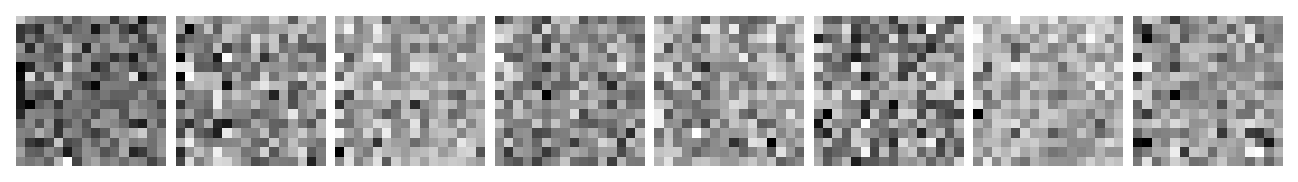

In [6]:
try:
    tr.model.show(nrows=1, order=np.argsort(dead))
except AttributeError:
    print(tr.model.cfg.dec_type)

In [7]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=5,
    active=~dead,
    full_data=True,
    return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['trn', 'vld', 'tst']
}

100%|███████████████████████████████████| 5/5 [00:32<00:00,  6.57s/it]


CPU times: user 1min 53s, sys: 1.1 s, total: 1min 54s
Wall time: 1min 40s


In [4]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

NameError: name 'results' is not defined

In [9]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

In [10]:
var = 'state_final'

lr = LinearRegression().fit(
    X=results['trn'][var][:, ~dead],
    y=results['trn']['g'][:, [1, 3]],
)
r2 = {
    name: r2_score(
        y_true=d['g'][:, [1, 3]],
        y_pred=lr.predict(d[var][:, ~dead]),
        multioutput='raw_values')
    for name, d in results.items()
}
corr = {
    name: 1 - np.diag(sp_dist.cdist(
        XA=d['g'][:, [1, 3]].T,
        XB=lr.predict(d[var][:, ~dead]).T,
        metric='correlation',
    )) for name, d in results.items()
}

In [11]:
print('r2:')
display(r2)
print('\n')
print('corr:')
display(corr)

r2:

{'trn': array([0.21385639, 0.19959942]),
 'vld': array([0.20460621, 0.19410172]),
 'tst': array([-29.22340348, -51.41092668])}

corr:

{'trn': array([0.46244609, 0.44676551]),
 'vld': array([0.45291979, 0.44058487]),
 'tst': array([ 0.07829004, -0.13608229])}

r2:

{'trn': array([0.99632893, 0.99589208]),
 'vld': array([0.99572993, 0.99507107]),
 'tst': array([0.88304978, 0.86136709])}

corr:

{'trn': array([0.99821904, 0.99795285]),
 'vld': array([0.99791889, 0.9975354 ]),
 'tst': array([0.94752717, 0.93428711])}

In [12]:
%%time

kws = dict(
    seq_total=3000,
    seq_batch_sz=1000,
    n_data_batches=1,
    active=~dead,
    full_data=True,
    verbose=True,
    return_recon=True,
)
results_to_plot = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['trn', 'vld', 'tst']
}

100%|███████████████████████████████████| 1/1 [00:09<00:00,  9.65s/it]


CPU times: user 42.1 s, sys: 9.45 s, total: 51.5 s
Wall time: 36.8 s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

trn

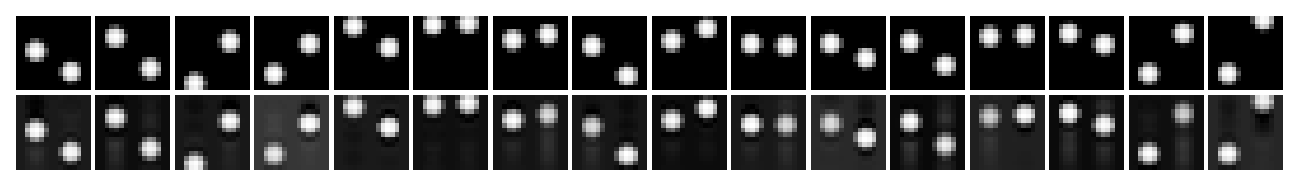

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

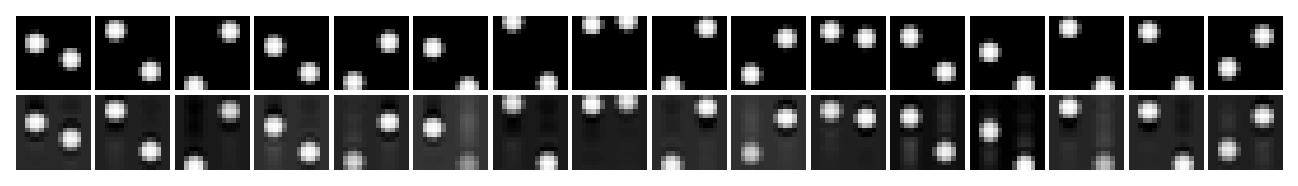

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

tst

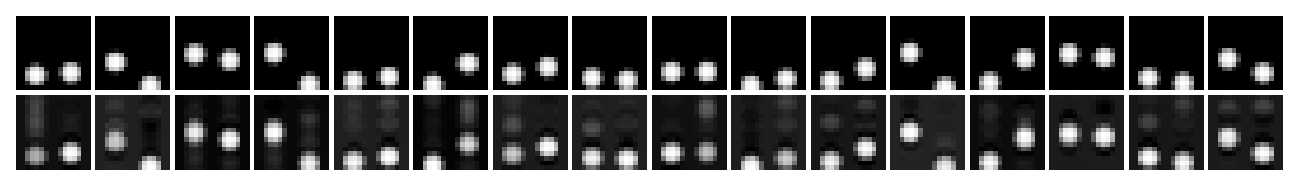

In [13]:
num = 16
shape = (tr.model.cfg.input_sz, ) * 2

for name, d in results_to_plot.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)
    
    x2p = np.concatenate([
        d['x'][:num, 0],
        d['y'][:num, -1].reshape(-1, *shape),
    ])
    _ = plot_weights(x2p, nrows=2)

In [ ]:
list(d)

In [ ]:
results['tst']['z_final'][100], np.round(results['tst']['state_final'][100], 5)

In [ ]:
plt.plot(np.exp(results['trn']['state_final'][100][~tonp(dead)]), marker='o');

In [ ]:
plt.plot(np.exp(results['tst']['state_final'][120, ~tonp(dead)]), marker='o');

## Best:

- BALLS64]
- lin
- low beta

In [21]:
r2

{'trn': array([0.99227716, 0.99063825]),
 'vld': array([0.9831758 , 0.98419235]),
 'tst': array([0.70075178, 0.63438643])}

In [22]:
corr

{'trn': array([0.99613414, 0.99532226]),
 'vld': array([0.99157756, 0.99210476]),
 'tst': array([0.8577958 , 0.84957657])}